In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt

from torchvision.models import vgg19, vgg16
from PIL import Image
from torchvision.transforms import Compose, ToTensor, Resize, Normalize

In [2]:
def imshow(im):
  plt.figure()
  plt.imshow(im)
  plt.show()

def im_convert(tensor):
    image = tensor.to("cpu").clone().detach()
    image = image.numpy().squeeze()
    image = image.transpose(1, 2, 0)
    image = image * np.array((0.229, 0.224, 0.225)) + np.array(
        (0.485, 0.456, 0.406))
    image = image.clip(0, 1)

    return image

In [3]:
style = Image.open('./images/picasso.jpg')
content = Image.open('./images/dancing.jpg')

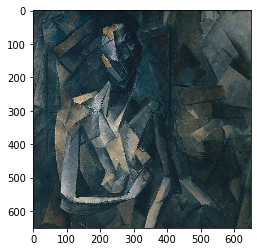

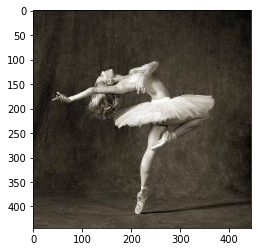

In [4]:
imshow(style)
imshow(content)

In [5]:
style = Image.open('./images/urlo.jpg')
content = Image.open('./images/paolo.jpeg')

RESIZE = 244
width, height = content.size
import numpy as np
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

mean = torch.tensor([0.485, 0.456, 0.406])
std = torch.tensor([0.229, 0.224, 0.225])

# transform = Compose([Resize((RESIZE, RESIZE)), ToTensor()])
transform = Compose([Resize((RESIZE, RESIZE)), ToTensor(), Normalize(mean=mean, std=std)])

def loader(pil_im, transform=transform):
  return transform(pil_im).unsqueeze(0).to(device).float()

In [6]:
cnn = vgg19(True).features
for param in cnn.parameters():
  param.requires_grad_(False)

for i, layer in enumerate(cnn):
  if isinstance(layer, torch.nn.MaxPool2d):
    cnn[i] = torch.nn.AvgPool2d(kernel_size=2, stride=2, padding=0)

cnn = cnn.to(device).eval()

In [7]:
class ContentLoss(nn.Module):
    def __init__(self, target):
        super().__init__()
        self.target = target.detach()

    def __call__(self, x):
        return F.mse_loss(x, self.target)

class GradMatrix(nn.Module):
    def __init__(self, input):
        super().__init__()
        b, n, h, w = input.size()
        features = input.view(b * n, h * w)  # resise F_XL into \hat F_XL
        G = torch.mm(features, features.t())  # compute the gram product
        # we 'normalize'
        # self.matrix = G.div(b * n * h * w)
        self.matrix = G
    def __call__(self):
        return self.matrix


class StyleLoss(nn.Module):
    def __init__(self, target):
        super().__init__()
        self.grad_target = GradMatrix(target.detach())()

    def __call__(self, x):
        grad_x = GradMatrix(x)()
        b, n, h, w = x.size()
        return F.mse_loss(grad_x, self.grad_target) / (b * n * h * w)



In [8]:
from functools import partial
from collections import OrderedDict

class StoreFeatures():
    def __init__(self, module, layers):
        self.module = module
        self.layers = layers
        self._state =  OrderedDict({})
        self.register_forward_hooks()
        self.unsubcribe = []
        
    def register_forward_hooks(self):
        i = 0
        for module in self.module.children():
            is_in_layers = i in self.layers
            if is_in_layers:
                name = f"layer_{i}"
                self.unsubcribe.append(module.register_forward_hook(partial(self.hook, name=name)))
                print(f'[INFO] hook registered to {module}')
            i += 1

        
    def hook(self, m, i, o, name):
        self._state[name] = o
    
    def clear(self):
        [un.remove() for un in storage.unsubcribe]

    def __call__(self, x):
        self.module(x)
        
        return self._state[self.key
        
    def __repr__(self):
        return str({k: [e.shape for e in v] for k, v in self._state.items()})    
    
    def __getitem__(self, key):
        return self._state[key]

SyntaxError: invalid syntax (<ipython-input-8-41c7fc3b728b>, line 28)

In [ ]:
storage = StoreFeatures(cnn, [cnn[0], cnn[5]])
storage(content_x, 'foo')

In [32]:
from functools import partial
from collections import OrderedDict


class StyleAndContentLoss(nn.Module):
    def __init__(self, module, style_layers, style_layers_weights):
        super().__init__()
        self.module = module
        self.style_layers = style_layers
        self.style_layers_weights = style_layers_weights
        
        self.features = OrderedDict()
        self.unsubcribe = []
        self.register_forward_hooks()


    def hook(self, m, i, o, name=None):
        print(name)
        self.features[self.key][name] = o

    def register_forward_hooks(self):
        i = 0
        for module in self.module.children():
            is_conv = type(module) is nn.Conv2d
            if is_conv:
                is_a_style_layer = i in self.style_layers
                if is_a_style_layer:
                    name = hash(module)
                    self.unsubcribe.append(module.register_forward_hook(partial(self.hook, name=name)))
                    print(f'[INFO] hook registered to {module}')
            i += 1

    def forward(self, content, style):
        self.features = OrderedDict({'inputs': {}, 'styles': {}, 'contents': {}})
        self.key = 'contents'
        self.module(content)
        self.key = 'styles'
        self.module(style)
        self.key = 'inputs'
        
    def clear(self):
        [un.remove() for un in self.unsubcribe]
    def compute_loss(self, device):
        content_loss = ContentLoss( self.features['contents'][4])(self.features['inputs'][4])
        style_loss =0

        for i, (input, content, style) in enumerate(zip(self.features['inputs'], self.features['contents'],  self.features['styles'])):
            # content_loss += ContentLoss(content)(input)
            style_loss += StyleLoss(style)(input) * self.style_layers_weights[i]


        self.features['inputs'] = []
        # print(f"[INFO] style={style_loss.item()} content={content_loss.item()}")
        # print(f"[INFO] {style_loss}")
        return (content_loss * 1e4) + (style_loss * 1e3)

    def __repr__(self):
        return str({k: [e.shape for e in v] for k, v in self.features.items()})

In [33]:
criterion = StyleAndContentLoss(cnn, style_layers, style_layers_weights)
criterion(content_x, style_x)
criterion.clear()

[INFO] hook registered to -9223363268497477807
[INFO] hook registered to 8768356197268
[INFO] hook registered to -9223363268498578474
[INFO] hook registered to 8768357263687
[INFO] hook registered to 8768357513925
-9223363268497477807
8768356197268
conv_5
-9223363268498578474
8768357263687
conv_10
8768357513925
-9223363268497477807
8768356197268
conv_5
-9223363268498578474
8768357263687
conv_10
8768357513925


In [25]:
criterion.features

OrderedDict([('inputs', {}),
             ('styles',
              {'conv_0': tensor([[[[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
                         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
                         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
                         ...,
                         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
                         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
                         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],
               
                        [[0.3896, 0.4780, 0.8720,  ..., 0.9643, 1.0758, 0.9323],
                         [0.0137, 0.3909, 0.7150,  ..., 1.3421, 1.4859, 1.8256],
                         [0.0000, 0.0000, 0.0000,  ..., 1.2126, 1.2283, 2.4083],
                         ...,
                         [0.0000, 0.0000, 1.0665,  ..., 0.3910, 0.5030, 0.7278],
                         [0.0000, 0.0000, 0.0790, 

In [11]:
style_layers = [0, 5, 10, 19, 28]
style_layers_weights = [ 0.75, 0.5, 0.2, 0.2, 0.2]


content_x = loader(content)
style_x = loader(style)
content_weight = 1e4
style_weight = 1e2

cnn = cnn.to(device).eval()


In [ ]:
criterion = StyleAndContentLoss(cnn, style_layers, style_layers_weights)
criterion(content_x, style_x)

# x = content_x.clone().requires_grad_(True).to(device)
x = torch.randn_like(content_x).requires_grad_(True).to(device)
optimizer = optim.Adam([x], 0.01)

In [ ]:
list(cnn.children())